In [52]:
import numpy as np
import os
import numpy as np
import uncertainties as u
from uncertainties import ufloat
from uncertainties.umath import sqrt
from uncertainties.umath import __all__
from uncertainties.umath import *
import uncertainties.unumpy as unp
import scipy.constants
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas # pip install Jinja2
import pint # pip install pint OR conda install pint
units = pint.UnitRegistry()
units.default_format = '~'
import warnings
warnings.simplefilter("ignore")
cm = 1/2.54

CIRCLE_DEG = 360.0
CIRCLE_RAD = 2*scipy.constants.pi
HALF_CIRCLE_RAD = scipy.constants.pi
DEG_PER_RAD = CIRCLE_DEG / CIRCLE_RAD

def r2d(x):
    return x*DEG_PER_RAD

def extr_values(np_arr):
    return unp.nominal_values(np_arr)

def extr_sig(np_arr):
    return unp.std_devs(np_arr)

def strip_units(np_arr):
    return np.array([(a.to_base_units().magnitude if type(a)!=float else a) for a in np_arr])

def errorbar_plot_with_linregress(X, Y, SIG_Y, errbarlabel='errbarlabel', xlabel='xlabel', ylabel='ylabel', errbarcolor='blue', linfitlabel='linfitlabel', nolinregress=False, saveas='tmp.png'):
    result = scipy.stats.linregress(X, Y)
    #slope, intercept, rvalue, pvalue, sevalue, inteerr
    print("slope: ", result.slope)
    print("slope_err:", result.stderr)
    print("intercept: ", result.intercept)
    x_axis_spaced = np.linspace(np.min(X), np.max(X), 10)
    fig, ax = plt.subplots(1,1,figsize=(8*cm, 8*cm))
    #ax.plot(x,y,linestyle='-', color='red')
    if not nolinregress:
        ax.plot(x_axis_spaced, result.slope*x_axis_spaced + result.intercept, 'r--', label=linfitlabel)
    ax.errorbar(X, Y, yerr=SIG_Y, linestyle='-', color=errbarcolor, capsize=3, label=errbarlabel)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.set_xlim([-1,1])
    #ax.set_ylim([-4,4])
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(saveas, dpi=500)
    plt.show()
    if not nolinregress:
        return u.ufloat(result.slope, result.stderr), u.ufloat(result.intercept, result.intercept_stderr) # (slope+=unc), (intercept+=unc)

slope:  0.5591428571428572
slope_err: 0.18855605997978966
intercept:  6815.142857142857


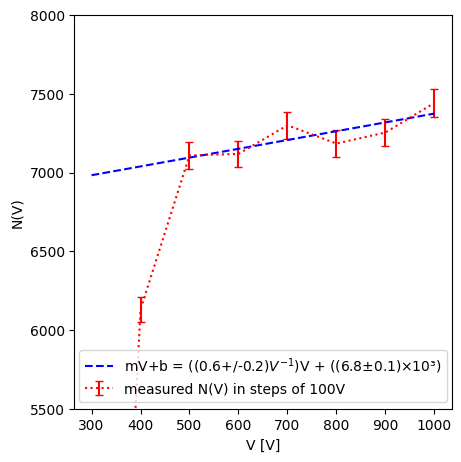

(0.5591428571428572+/-0.18855605997978966,
 6815.142857142857+/-145.03707947200505)

In [53]:
# Import meas 1
V_volt_meas, t_seconds_meas, N_of_V_meas = np.genfromtxt(os.path.join(os.getcwd(), "meas_1.csv"), delimiter=',', skip_header=1, unpack=True)

u_V = np.array([u.ufloat(V_val, 5.0) for V_val in V_volt_meas])
u_t = np.array([u.ufloat(t_val, 2.0/1000) for t_val in t_seconds_meas])
u_N = np.array([u.ufloat(N_val, np.sqrt(N_val)) for N_val in N_of_V_meas])

def graph_N(V, N, sig_N):
    X, Y = V[2:], N[2:]
    result = scipy.stats.linregress(X, Y)
    u_Slope = u.ufloat(result.slope, result.stderr)
    u_Intercept = u.ufloat(result.intercept, result.intercept_stderr)
    #slope, intercept, rvalue, pvalue, sevalue, inteerr
    print("slope: ", result.slope)
    print("slope_err:", result.stderr)
    print("intercept: ", result.intercept)
    x_axis_spaced = np.linspace(np.min(V), np.max(V), 10)
    fig, ax = plt.subplots(1,1,figsize=(12*cm, 12*cm))
    #ax.plot(x,y,linestyle='-', color='red')
    ax.errorbar(V, N, yerr=sig_N, linestyle='dotted', color='red', capsize=3, label='measured N(V) in steps of 100V')
    ax.plot(x_axis_spaced, result.slope*x_axis_spaced + result.intercept, 'b--', label=r'mV+b = (({:.1u}){})V + ({:.1uP})'.format(u_Slope, r'$V^{-1}$', u_Intercept))
    ax.set_xlabel('V [V]')
    ax.set_ylabel('N(V)')
    ax.set_ylim([5500, 8000])
    ax.legend(loc='lower center')
    plt.tight_layout()
    plt.savefig('N_of_V', dpi=500)
    plt.show()
    return u_Slope, u_Intercept # (slope+=unc), (intercept+=unc)

graph_N(extr_values(u_V), extr_values(u_N), extr_sig(u_N))

In [54]:
# 2. Aktivität der Quelle
u_t = u.ufloat(120, 2/1000) # s
u_N2 = u.ufloat(9688, np.sqrt(9688)) # Einfallende Teilchen in der Zeit t
u_N_bg = u.ufloat(74, np.sqrt(74))
u_N_eff = u_N2 - u_N_bg
if (u.std_dev(u_N_eff) <= np.sqrt(u.nominal_value(u_N_eff))):
    u_N_eff = u.ufloat(u.nominal_value(u_N_eff), np.sqrt(u.nominal_value(u_N_eff)))
    print("Sqrt was higher than propagaded uncertainty so we took this for u_N_eff")
else:
    print("Propagated uncertainty from N and N_BG was taken instead of sqrt N_eff for the uncertainty")
print("N = {:.2u}, N_bg = {:.2u}, N_eff = {:.2u}".format(u_N2, u_N_bg, u_N_eff))

# Raumwinkelberechnung
u_D = u.ufloat(17.2, 0.5) # mm
u_r = u_D/2 # mm
u_d = u.ufloat(101, 0.5) # mm
u_theta = u.wrap(np.arctan)(u_r/u_d) # rad
print("theta = {:.2u}".format(u_theta))
print("theta in degrees = {:.2u}".format(r2d(u_theta)))

u_epsilon = u.wrap(np.square)(u.wrap(np.sin)(u_theta/2))
print("epsilon = {:.2u}".format(u_epsilon))

# Aktivität
u_Aktivitaet = u_N_eff / (u_t * u_epsilon)

print("Aktivität der Probe = {:.2u}".format(u_Aktivitaet))

Propagated uncertainty from N and N_BG was taken instead of sqrt N_eff for the uncertainty
N = 9688+/-98, N_bg = 74.0+/-8.6, N_eff = 9614+/-99
theta = 0.0849+/-0.0025
theta in degrees = 4.87+/-0.14
epsilon = 0.00180+/-0.00011
Aktivität der Probe = (4.44+/-0.26)e+04


In [55]:
u_reach_Sr = u.ufloat(0.45, 0.005) # Just set a value for uncertainty
u_not_reach_Sr = 1 - u_reach_Sr
u_reach_Y = u.ufloat(0.9, 0.005)
u_not_reach_Y = 1 - u_reach_Y

u_rate_Sr = u.ufloat(0.5, 0.005)
u_rate_Y = u.ufloat(0.5, 0.005)

u_fact = 1/(u_rate_Sr * u_reach_Sr + u_rate_Y * u_reach_Y)
print("correction factor {:.1u}".format(u_fact))

u_Aktivitaet_Corrected = u_fact * u_Aktivitaet
print("Aktivität Corrected = {:.2u}".format(u_Aktivitaet_Corrected))

correction factor 1.48+/-0.01
Aktivität Corrected = (6.58+/-0.40)e+04


In [56]:
# 3
# a.
def s2y(x):
    return 1.0 * x / 60 / 60 / 24 / 365.25
def s2h(x):
    return 1.0 * x / 60 / 60

halbwertszeit_Sr = 28.8 * 365.25 * 24 * 60 * 60 # s
halbwertszeit_Y = 64 * 60 * 60 # s

Tau_Sr = halbwertszeit_Sr / np.log(2)
Tau_Y = halbwertszeit_Y / np.log(2)

print("Tau Sr: {:.2f} years".format(s2y(Tau_Sr)))
print("Tau Y: {:.2f} years".format(s2y(Tau_Y)))
print("Tau Y {:.2f} hours".format(s2h(Tau_Y)))

def activity_function(N0, Tau):
    return lambda t: N0*np.exp(-t/Tau)

time_since_1_1_1950 = 2299276800 # seconds

print("3a activity then {:.1u}".format(activity_function(u_Aktivitaet_Corrected, Tau_Sr)(-time_since_1_1_1950)))

# b.

def solve_t_after_which_activityN(Tau, N, N0):
    return -Tau * u.wrap(np.log)(N/N0)

N_parameter = 10.0e+03

print("3b activita goes to 10kBq in {:.1u} years".format(s2y(solve_t_after_which_activityN(Tau_Sr, N_parameter, u_Aktivitaet_Corrected))))


Tau Sr: 41.55 years
Tau Y: 0.01 years
Tau Y 92.33 hours
3a activity then (3.8+/-0.2)e+05
3b activita goes to 10kBq in 78+/-3 years


In [4]:
# 3c
y90stuff = 1.6
sr90stuff = 1.4

# TODO TODO TODO TODO TODO TODO


98.05100713404222